In [1]:
import sys
sys.path.insert(0, "..")
from classes.calculators.lennardjones import LJGauss
import matplotlib.pyplot as plt
import torch
import numpy as np

In [2]:
class NNmodel(torch.nn.Module):
    def __init__(self, num_hidden_layers, dim_hiddens, activation_func, bias=True) -> None:
        super().__init__()
        self.num_hidden_layers = num_hidden_layers
        self.acc_func = activation_func
        self.hidden_layers = torch.nn.ParameterList()
        self.input_layer = torch.nn.Linear(1, dim_hiddens, bias=bias)
        self.output_layer = torch.nn.Linear(dim_hiddens, 1, bias=bias)
        for num in range(num_hidden_layers):
            self.hidden_layers.append(torch.nn.Linear(dim_hiddens, dim_hiddens, bias=bias))

    def forward(self, x):
        x = self.acc_func(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.acc_func(layer(x))
        return self.output_layer(x)

class NN_single_layer(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.w = torch.nn.Parameter(data=torch.tensor([1.0]), requires_grad=True)
        self.b = torch.nn.Parameter(data=torch.tensor([1.0]), requires_grad=True)
    
    def forward(self, x):
        return self.w*x + self.b

def train_model(model, train_xs, train_ys, optimizer, N_steps=5000,loss_func=torch.nn.MSELoss()):
    loss_vals = []
    for step in range(N_steps):
        optimizer.zero_grad()
        loss = loss_func(train_ys, model.forward(train_xs))
        loss_vals.append(loss)
        loss.backward()
        optimizer.step()
    return loss_vals

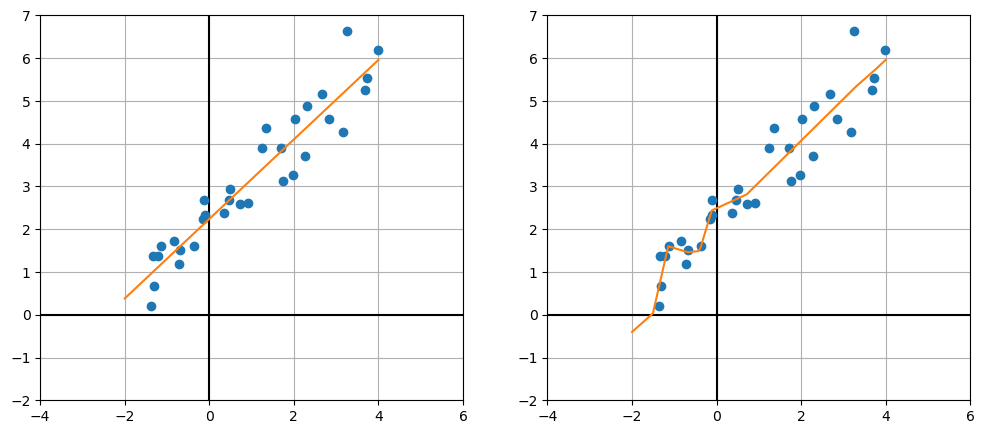

In [28]:
def lin_func(xs, a=1.0, b=2.0):
    return a*xs + b

fig, axs = plt.subplots(1,2, figsize=(12,5))
xs_train = torch.rand(32)*6 - 2
ys_train = lin_func(xs_train) + .5*torch.randn(len(xs_train))

simple_model = NN_single_layer()
large_model = NNmodel(num_hidden_layers=2, dim_hiddens=8, activation_func=torch.nn.ReLU(),bias=True)

xs = torch.linspace(-2, 4, 1000)

for ax, model in zip(axs, [simple_model, large_model]):
    ax.set_ylim([-2.0, 7.0])
    ax.set_xlim([-4.0, 6.0])
    ax.vlines(x=0, ymin=-5, ymax=16, colors="k")
    ax.hlines(y=0, xmin=-5, xmax=16, colors="k")
    ax.grid()
    ax.plot(xs_train, ys_train, 'o')
    optimizer = torch.optim.SGD(params=model.parameters(), lr=1e-2)
    _ = train_model(model=model, train_xs=xs_train.view(-1,1), train_ys=ys_train.view(-1,1), optimizer=optimizer, N_steps=20000)
    with torch.no_grad():
        ax.plot(xs.view(-1,1), model(xs.view(-1,1)))


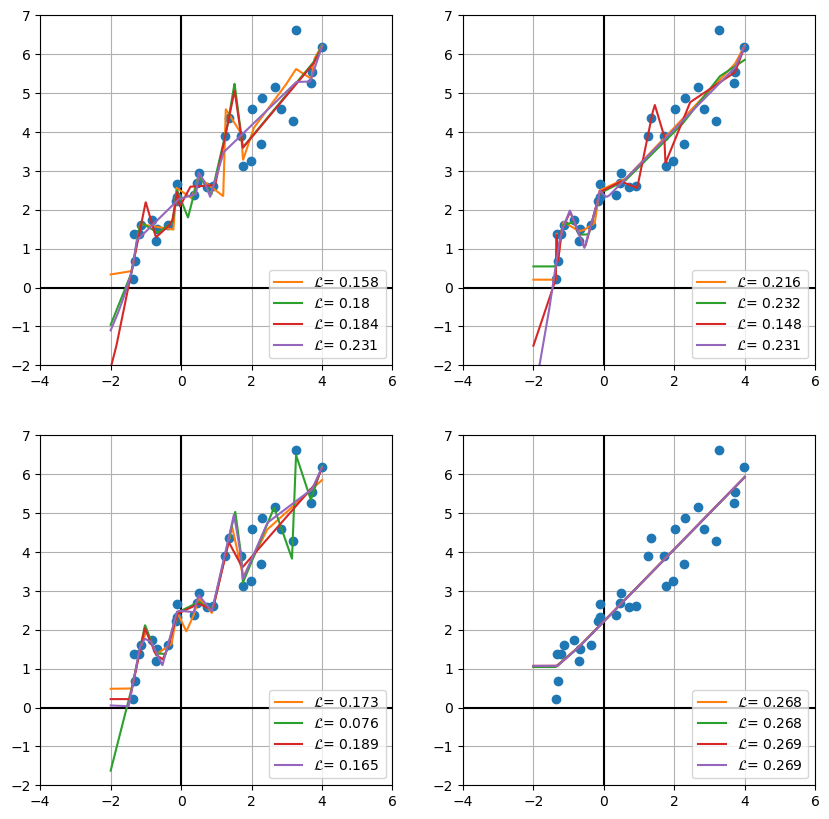

In [30]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
w_decays = [0.0, 1e-5, 1e-3, 0.1]
for ax, w_decay in zip(axs.flatten(), w_decays):
    ax.set_ylim([-2.0, 7.0])
    ax.set_xlim([-4.0, 6.0])
    ax.vlines(x=0, ymin=-5, ymax=16, colors="k")
    ax.hlines(y=0, xmin=-5, xmax=16, colors="k")
    ax.grid()
    ax.plot(xs_train, ys_train, 'o')
    for i in range(4):
        model = NNmodel(num_hidden_layers=2, dim_hiddens=8, activation_func=torch.nn.ReLU(),bias=True)
        optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-2, weight_decay=w_decay)
        loss_vals = train_model(model=model, train_xs=xs_train.view(-1,1), train_ys=ys_train.view(-1,1), optimizer=optimizer, N_steps=20000)
        with torch.no_grad():
            ax.plot(xs.view(-1,1), model(xs.view(-1,1)), label=r"$\mathcal{L}$="+f" {str(loss_vals[-1].numpy().round(3))}")
    ax.legend(loc="lower right")